In general, this notebook is designed to specifically work with how other teammates present their data. Do not attempt to use this notebook without previously prepared datasets either local or on the cloud, otherwise heavy modification will be needed to integrate previous data processing pipelines.

# HYPERPARAMS

nothing needs to be changed here, since we are not training, but we do specify we use cuda for workload,

In [ ]:

hyper = {
    # ---- General ----
    "seed": 1337,
    "device": "cuda",             # used for PyTorch (heads & AudioMAE)
    "runtime_root": "/content",
    "dataset_root": "medley_work",
    "target_sr": 16000,
    "use_amp": True,
    "num_workers": 4,

    # ---- Splits (track-level stratified) ----
    "split_val_ratio": 0.15,
    "split_test_ratio": 0.15,

    # ---- Augmentation ----
    "aug_reverb_prob": 0.7,
    "aug_reverb_wet": (0.1, 0.5),
    "aug_ambience_prob": 0.8,
    "aug_ambience_snr": (0, 20),
    "aug_dist_prob": 0.3,
    "aug_dist_drive": (0.5, 1.5),
    "synthetic_rir_rt60": (0.2, 1.2),  # fallback if no IR files found

    # ---- OpenL3 (TensorFlow GPU) ----
    "openl3_input_repr": "mel256",
    "openl3_content": "music",
    "openl3_embed_dim": 512,
    "openl3_hop": 0.1,
    "openl3_batch_pooled": 64,
    "openl3_batch_seq": 16,
    "openl3_batchsize_tf": 64,   # TF batch size inside get_audio_embedding

    # ---- AudioMAE (PyTorch HF) ----
    "audiomae_model_id": "facebook/audio-mae-base",
    "audiomae_batch_pooled": 32,
    "audiomae_batch_seq": 16,

    # ---- Training (PyTorch heads) ----
    "epochs": 25,
    "lr": 3e-4,
    "weight_decay": 0.05,
    "width_mlp": 1024,
    "dropout": 0.2,

    # ---- Real IR / Ambience URLs ----
    "ir_urls": [
        "https://mcdermottlab.mit.edu/Reverb/IRMAudio/Audio.zip",
        "https://webfiles.york.ac.uk/OPENAIR/IRs/tvisongur-sound-sculpture-iceland-model/stereo/source1domefareceiver2domelabinaural.wav"

    ],
    "amb_urls": [
        "https://upload.wikimedia.org/wikipedia/commons/7/76/Ambience_noise_at_1_am_in_Bengaluru%2C_Karnataka%2C_India.wav",
        "https://upload.wikimedia.org/wikipedia/commons/5/54/Cafe_ambiance.ogg",
    ],
}


# SETUP


get the openl3 model


clone the openl3 repo, this can be much easier with pip if we use pip and a custom python environment, but on colab we directly use the repo due to compatability issues.

In [ ]:
!git clone https://github.com/marl/openl3.git /content/openl3


Cloning into '/content/openl3'...
remote: Enumerating objects: 1576, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 1576 (delta 97), reused 135 (delta 88), pack-reused 1403 (from 1)
Receiving objects: 100% (1576/1576), 703.62 MiB | 30.49 MiB/s, done.
Resolving deltas: 100% (980/980), done.


install dependencies that colab does not come with.

In [ ]:
#openl3 dependants
!pip install resampy
!pip install kapre

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.6 MB/s eta 0:00:00


set up imports and tensorflow

In [ ]:
# 2) Imports & paths
import os, glob, zipfile, subprocess, shutil, random, sys, gzip, shutil, urllib.request
from pathlib import Path

import numpy as np, pandas as pd, librosa, soundfile as sf, matplotlib.pyplot as plt
from tqdm.auto import tqdm
import scipy.signal as sig

import math, threading
from typing import Dict, Tuple, List, Optional

from pathlib import Path
import zipfile


# PyTorch for heads & AudioMAE
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoFeatureExtractor, AutoModel

# insert the onpenl3 path
REPO = "/content/openl3"
assert os.path.isdir(REPO) and os.path.isdir(os.path.join(REPO, "openl3"))
if REPO not in sys.path:
    sys.path.insert(0, REPO)  # repo takes precedence

# TensorFlow GPU for openl3 embeddings
import tensorflow as tf, openl3

# ---- TF GPU config (memory growth to avoid OOM) ----
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass
print("TF GPUs:", gpus)

SEED = hyper["seed"]
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)

DEVICE = "cuda" if (torch.cuda.is_available() and hyper["device"]=="cuda") else "cpu"
TARGET_SR = hyper["target_sr"]; USE_AMP = hyper["use_amp"]

ROOT = Path(hyper["runtime_root"]) / hyper["dataset_root"]
AUDIO_RAW = ROOT / "audio_raw"; AUDIO_16K = ROOT / "audio_16k"
IR_DIR = ROOT / "irs"; AMB_DIR = ROOT / "ambiences"; CACHE = ROOT / "cache"; TMP = ROOT / "tmp"
for p in [ROOT, AUDIO_RAW, AUDIO_16K, IR_DIR, AMB_DIR, CACHE, TMP]: p.mkdir(parents=True, exist_ok=True)
print("PyTorch device:", DEVICE)


TF GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
PyTorch device: cuda


Get the openl3 weights

don't need to change anything here, the weights are stored on runtime disk.

In [ ]:
# destination folder where openl3 looks for weights
DEST_DIR = "/content/openl3/openl3"
os.makedirs(DEST_DIR, exist_ok=True)

# GitHub release where all .h5.gz weights are stored
RELEASE_VER = "v0_4_0"
BASE_URL = f"https://github.com/marl/openl3/raw/models/"

modalities   = ["audio", "image"]
input_reprs  = ["linear", "mel128", "mel256"]
content_type = ["music", "env"]

for m in modalities:
    for r in input_reprs:
        for c in content_type:
            base = f"openl3_{m}_{r}_{c}"
            gz_name = f"{base}-{RELEASE_VER}.h5.gz"
            gz_path = os.path.join(DEST_DIR, gz_name)
            h5_path = os.path.join(DEST_DIR, f"{base}.h5")

            if os.path.exists(h5_path):
                print(f"✓ {os.path.basename(h5_path)} already exists")
                continue

            url = BASE_URL + gz_name
            print(url)
            print(f"↓ Downloading {gz_name} ...")
            urllib.request.urlretrieve(url, gz_path)

            print(f"• Decompressing {gz_name} ...")
            with gzip.open(gz_path, "rb") as src, open(h5_path, "wb") as dst:
                shutil.copyfileobj(src, dst)

            os.remove(gz_path)
            print(f"✓ Saved {os.path.basename(h5_path)}\n")

print("✅ All OpenL3 weight files are downloaded to:", DEST_DIR)

https://github.com/marl/openl3/raw/models/openl3_audio_linear_music-v0_4_0.h5.gz
↓ Downloading openl3_audio_linear_music-v0_4_0.h5.gz ...
• Decompressing openl3_audio_linear_music-v0_4_0.h5.gz ...
✓ Saved openl3_audio_linear_music.h5

https://github.com/marl/openl3/raw/models/openl3_audio_linear_env-v0_4_0.h5.gz
↓ Downloading openl3_audio_linear_env-v0_4_0.h5.gz ...
• Decompressing openl3_audio_linear_env-v0_4_0.h5.gz ...
✓ Saved openl3_audio_linear_env.h5

https://github.com/marl/openl3/raw/models/openl3_audio_mel128_music-v0_4_0.h5.gz
↓ Downloading openl3_audio_mel128_music-v0_4_0.h5.gz ...
• Decompressing openl3_audio_mel128_music-v0_4_0.h5.gz ...
✓ Saved openl3_audio_mel128_music.h5

https://github.com/marl/openl3/raw/models/openl3_audio_mel128_env-v0_4_0.h5.gz
↓ Downloading openl3_audio_mel128_env-v0_4_0.h5.gz ...
• Decompressing openl3_audio_mel128_env-v0_4_0.h5.gz ...
✓ Saved openl3_audio_mel128_env.h5

https://github.com/marl/openl3/raw/models/openl3_audio_mel256_music-v0_4_0.h

debug


simple block to test if openl3 is up

In [ ]:
print("TF:", tf.__version__, "| GPUs:", tf.config.list_physical_devices('GPU'))

# Load pretrained OpenL3
l3 = openl3.models.load_audio_embedding_model("mel256", "music", 512)

# 1s sine @16 kHz
sr = 16000
t = np.linspace(0, 1, sr, endpoint=False, dtype=np.float32)
y = 0.2*np.sin(2*np.pi*440*t).astype(np.float32)

E, ts = openl3.core.get_audio_embedding(y, sr, model=l3, hop_size=0.1, center=True, batch_size=64)
print("Embeddings:", E.shape, "frames:", len(ts))

TF: 2.19.0 | GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Embeddings: (6, 512) frames: 6


# DOWNLOAD DATA

Manual Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


for reverb

block that processes the dataset from previous pipelines, so team mates uploaded audio files in folders and a csv of these clips. This block is to decompress, extract, and form a dataset at runtime. Highly specialized to the certain file structure and naming we are using for the medleydb set and the data structure of medleydb, will not work smoothly with other datastructure. PLease refer to data augmentation pielines for how they specifcally output files.

In [ ]:
# =========================
# 1) Paths (Google Drive)
# =========================
# Folder in your Drive that contains:
#   - audio_1000_balanced.zip
#   - audio_1000_balanced_Reverb1.zip ... Reverb10.zip
#   - audio_labels_1000_balanced.csv
#   - reverb_csv_1-10.zip  (or similar)
DATA_ROOT = Path("/content/drive/MyDrive/medley_db_enhanced")

# We'll extract audio next to the zips (into subfolders)
OUT_AUDIO = DATA_ROOT   # so /medley_db_enhanced/audio_1000_balanced*, etc.

BASE_ZIP = DATA_ROOT / "audio_1000_balanced.zip"
REVERB_ZIPS = [DATA_ROOT / f"audio_1000_balanced_Reverb{i}.zip" for i in range(1, 11)]

BASE_CSV   = DATA_ROOT / "audio_labels_1000_balanced.csv"
REVERB_CSV = DATA_ROOT / "reverb_csv_1-10.zip"   # or a single CSV if that's what you have

AUDIO_EXTS = (".wav", ".aiff", ".aif", ".flac", ".ogg", ".mp3", ".m4a")

# =========================
# 2) Unzip audio into folders
#    /medley_db_enhanced/audio_1000_balanced
#    /medley_db_enhanced/audio_1000_balanced_Reverb1
#    ...
# =========================
def unzip_to(zip_path: Path, out_dir: Path):
    """Extract only audio files to a subfolder named after the zip stem."""
    if not zip_path.exists():
        print("Missing:", zip_path)
        return
    sub = out_dir / zip_path.stem
    sub.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        members = [m for m in zf.namelist() if m.lower().endswith(AUDIO_EXTS)]
        for m in tqdm(members, desc=f"Extract → {zip_path.stem}"):
            tgt = sub / Path(m).name
            if not tgt.exists():
                with zf.open(m) as src, open(tgt, "wb") as dst:
                    dst.write(src.read())

# Unpack base + all reverbs
unzip_to(BASE_ZIP, OUT_AUDIO)
for z in REVERB_ZIPS:
    unzip_to(z, OUT_AUDIO)

# =========================
# 3) Robust CSV reader for reverb CSVs
# =========================
def read_reverb_csvs(zip_or_csv: Path) -> pd.DataFrame:
    """Read one ZIP of CSVs or a single CSV, with encoding fallback."""
    def read_one(fobj):
        try:
            return pd.read_csv(fobj)
        except UnicodeDecodeError:
            fobj.seek(0)
            return pd.read_csv(fobj, encoding="latin1")

    if zip_or_csv.suffix.lower() == ".zip":
        with zipfile.ZipFile(zip_or_csv, "r") as zf:
            csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
            frames = []
            for name in csv_names:
                with zf.open(name) as f:
                    frames.append(read_one(f))
            return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
    else:
        try:
            return pd.read_csv(zip_or_csv)
        except UnicodeDecodeError:
            return pd.read_csv(zip_or_csv, encoding="latin1")

# Base (dry) CSV
base_df = pd.read_csv(BASE_CSV)
base_df["reverb_label"] = "Dry"

# Reverb CSV(s)
rev_df = read_reverb_csvs(REVERB_CSV)

# =========================
# 4) Merge + normalize column names
# =========================
df_all = pd.concat([base_df, rev_df], ignore_index=True)
df_all = df_all.rename(columns={c: c.strip().lower() for c in df_all.columns})

# If your uuid column isn't exactly "uuid4", auto-rename it:
if "uuid4" not in df_all.columns:
    uuid_candidates = [c for c in df_all.columns if "uuid" in c.lower()]
    if uuid_candidates:
        df_all = df_all.rename(columns={uuid_candidates[0]: "uuid4"})

# Same for reverb_label, if needed:
if "reverb_label" not in df_all.columns:
    rev_candidates = [c for c in df_all.columns if "reverb" in c.lower()]
    if rev_candidates:
        df_all = df_all.rename(columns={rev_candidates[0]: "reverb_label"})

# =========================
# 5) Resolve audio paths by uuid4 + reverb_label
# =========================
def find_path_for_uuid(uuid: str, reverb_label: str | None) -> str | None:
    uuid = str(uuid).lower()

    # First: try the specific reverb folder, e.g. audio_1000_balanced_Reverb4
    if reverb_label and reverb_label != "Dry":
        pref = OUT_AUDIO / f"audio_1000_balanced_{reverb_label}"
        if pref.exists():
            for p in pref.iterdir():
                if p.suffix.lower() in AUDIO_EXTS and uuid in p.stem.lower():
                    return p.as_posix()

    # Dry or fallback: search anywhere under OUT_AUDIO
    for p in OUT_AUDIO.rglob("*"):
        if p.suffix.lower() in AUDIO_EXTS and uuid in p.stem.lower():
            return p.as_posix()

    return None

paths = []
for r in tqdm(df_all.to_dict("records"), desc="Resolve audio paths"):
    paths.append(find_path_for_uuid(r.get("uuid4", ""), r.get("reverb_label")))
df_all["path"] = paths
df_all = df_all.dropna(subset=["path"]).reset_index(drop=True)

# Encode instrument labels into integers (y)
df_all["y"] = df_all["instrument"].astype("category").cat.codes
classes = list(df_all["instrument"].astype("category").cat.categories)

# Expose as `df` so later blocks that expect `df` still work
df = df_all

print("Rows:", len(df))
print("Instruments:", classes)
print(df[["subset", "instrument", "reverb_label", "uuid4", "path"]].head(5))


Extract → audio_1000_balanced:   0%|          | 0/2986 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb1:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb2:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb3:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb4:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb5:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb6:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb7:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb8:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb9:   0%|          | 0/2000 [00:00<?, ?it/s]

Extract → audio_1000_balanced_Reverb10:   0%|          | 0/2000 [00:00<?, ?it/s]

Resolve audio paths:   0%|          | 0/11000 [00:00<?, ?it/s]

Rows: 11000
Instruments: ['clarinet', 'distorted electric guitar', 'female singer', 'flute', 'piano', 'tenor saxophone', 'trumpet', 'violin']
       subset instrument reverb_label                                 uuid4  \
0  validation   clarinet          Dry  a826c559-0fc9-58b4-fddd-ba1adf1a10d1   
1  validation   clarinet          Dry  623f30e2-9d6b-5920-ff34-00a81adba1cd   
2        test   clarinet          Dry  a009d3dc-dd17-5a4d-fb88-73d99e046936   
3        test   clarinet          Dry  5c63f880-8f63-59b7-fa4e-62fd638a22b6   
4        test   clarinet          Dry  f94bcdb3-9b45-5375-f1b4-abac9cf23528   

                                                path  
0  /content/drive/MyDrive/medley_db_enhanced/audi...  
1  /content/drive/MyDrive/medley_db_enhanced/audi...  
2  /content/drive/MyDrive/medley_db_enhanced/audi...  
3  /content/drive/MyDrive/medley_db_enhanced/audi...  
4  /content/drive/MyDrive/medley_db_enhanced/audi...  


noise

the same block as the upper one only modified for the noise augmented set. The noise set presents data in a similar file structure as the reverb set.

In [ ]:
# =========================
# 1) Paths (Google Drive)
# =========================
DATA_ROOT = Path("/content/drive/MyDrive/medley_db_enhanced")

# 10 noise zips:
NOISE_ZIPS = [DATA_ROOT / f"augmentation_noise_part_{i:02d}.zip"
              for i in range(1, 11)]

# single labels CSV for the 10k noisy clips
NOISE_CSV = DATA_ROOT / "augmented_audio_labels_10000.csv"

# where to extract noisy audio
NOISE_AUDIO_ROOT = DATA_ROOT / "augmentation_noise_audio"
NOISE_AUDIO_ROOT.mkdir(parents=True, exist_ok=True)

AUDIO_EXTS = (".wav", ".aiff", ".aif", ".flac", ".ogg", ".mp3", ".m4a")

# =========================
# 2) Unzip noise audio
#    /.../augmentation_noise_audio/augmentation_noise_part_01
#    ...
# =========================
def unzip_to(zip_path: Path, out_dir: Path):
    """Extract only audio files to a subfolder named after the zip stem."""
    if not zip_path.exists():
        print("Missing:", zip_path)
        return
    sub = out_dir / zip_path.stem
    sub.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        members = [m for m in zf.namelist()
                   if m.lower().endswith(AUDIO_EXTS)]
        for m in tqdm(members, desc=f"Extract → {zip_path.stem}"):
            tgt = sub / Path(m).name
            if not tgt.exists():
                with zf.open(m) as src, open(tgt, "wb") as dst:
                    dst.write(src.read())

for z in NOISE_ZIPS:
    unzip_to(z, NOISE_AUDIO_ROOT)

# =========================
# 3) Read labels CSV
# =========================
def read_noise_csv(csv_path: Path) -> pd.DataFrame:
    try:
        return pd.read_csv(csv_path)
    except UnicodeDecodeError:
        return pd.read_csv(csv_path, encoding="latin1")

df_noise = read_noise_csv(NOISE_CSV)

# normalize column names
df_noise = df_noise.rename(columns={c: c.strip().lower()
                                    for c in df_noise.columns})

# ensure we have "uuid4" and "noise_category" column names
if "uuid4" not in df_noise.columns:
    uuid_candidates = [c for c in df_noise.columns if "uuid" in c.lower()]
    if uuid_candidates:
        df_noise = df_noise.rename(columns={uuid_candidates[0]: "uuid4"})

if "noise_category" not in df_noise.columns:
    noise_candidates = [c for c in df_noise.columns if "noise" in c.lower()]
    if noise_candidates:
        df_noise = df_noise.rename(columns={noise_candidates[0]: "noise_category"})

# =========================
# 4) Resolve audio paths by uuid4 + noise_category
# =========================
def find_noise_path(uuid: str, noise_category: str | None) -> str | None:
    """
    Search inside NOISE_AUDIO_ROOT for a file whose name contains the uuid,
    and (if available) the noise_category string.
    """
    uuid = str(uuid).lower()
    noise_category = (str(noise_category).lower()
                      if noise_category is not None else None)

    for p in NOISE_AUDIO_ROOT.rglob("*"):
        if p.suffix.lower() not in AUDIO_EXTS:
            continue
        name = p.stem.lower()
        if uuid in name:
            if (noise_category is None) or (noise_category in name):
                return p.as_posix()
    return None

paths = []
for r in tqdm(df_noise.to_dict("records"),
              desc="Resolve noise-augmented audio paths"):
    paths.append(find_noise_path(r.get("uuid4", ""),
                                 r.get("noise_category")))

df_noise["path"] = paths
df_noise = df_noise.dropna(subset=["path"]).reset_index(drop=True)

# Encode instruments into integer labels (like before)
df_noise["y"] = df_noise["instrument"].astype("category").cat.codes
noise_classes = list(df_noise["instrument"].astype("category").cat.categories)

# Optionally expose as `df` so the embedding code can reuse it directly
df = df_noise

print("Noise rows:", len(df_noise))
print("Instruments:", noise_classes)
print(df_noise[["subset", "instrument",
                "noise_category", "uuid4", "path"]].head(10))


Extract → augmentation_noise_part_01:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_02:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_03:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_04:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_05:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_06:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_07:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_08:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_09:   0%|          | 0/1000 [00:00<?, ?it/s]

Extract → augmentation_noise_part_10:   0%|          | 0/1000 [00:00<?, ?it/s]

Resolve noise-augmented audio paths:   0%|          | 0/10000 [00:00<?, ?it/s]

Noise rows: 10000
Instruments: ['clarinet', 'distorted electric guitar', 'female singer', 'flute', 'piano', 'tenor saxophone', 'trumpet', 'violin']
  subset instrument noise_category                                 uuid4  \
0   test      piano       ambience  005d3d9e-199d-5a94-f244-1758d173b2b9   
1   test      piano       applause  005d3d9e-199d-5a94-f244-1758d173b2b9   
2   test      piano           bird  005d3d9e-199d-5a94-f244-1758d173b2b9   
3   test      piano          crowd  005d3d9e-199d-5a94-f244-1758d173b2b9   
4   test      piano            fan  005d3d9e-199d-5a94-f244-1758d173b2b9   
5   test      piano     microphone  005d3d9e-199d-5a94-f244-1758d173b2b9   
6   test      piano           rain  005d3d9e-199d-5a94-f244-1758d173b2b9   
7   test      piano         street  005d3d9e-199d-5a94-f244-1758d173b2b9   
8   test      piano        talking  005d3d9e-199d-5a94-f244-1758d173b2b9   
9   test      piano    white_noise  005d3d9e-199d-5a94-f244-1758d173b2b9   

               

Split dataset

manual set data split

not really needed, can skip since we are not training.

In [ ]:
# ======= Splits (your loaders look for subset strings) =======
df = df_all.copy()

train_df = df[df["subset"].str.contains("train", case=False, na=False)].reset_index(drop=True)
val_df   = df[df["subset"].str.contains("validation", case=False, na=False)].reset_index(drop=True)
test_df  = df[df["subset"].str.contains("test", case=False, na=False)].reset_index(drop=True)

print("Counts:", len(train_df), len(val_df), len(test_df))
print("Reverbs in train:", train_df["reverb_label"].value_counts().to_dict())


embedding inference

loading one community hf audiomae model on the fly and getting embeddings for the reverb set for both openl3 and audiomae. Still, highly specialized for the file structure we are using, change the folder address as needed. Also, tqdm printouts will slow the browser. This block will output embeddings in .npy files for each audio clip, and one csv will be also provided for the embeddings. Audiomae will clip at 10s for audio clips, not a pipeline bug but a model design, need additional tweaking if intended to process data above 10s.

In [ ]:
# ====== Inference-only embeddings for ALL tracks (OpenL3 + AudioMAE) ======
import torch
from transformers import AutoConfig, AutoModel
from openl3 import models as o3models, core as o3core

# If you're in a fresh Colab session, re-mount Drive:
from google.colab import drive
drive.mount('/content/drive')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---------- 0) Paths (Google Drive) ----------
DATA_ROOT = Path("/content/drive/MyDrive/medley_db_enhanced")

EMB_ROOT   = DATA_ROOT / "embeds"
EMB_L3_DIR = EMB_ROOT / "openl3_mel256_music_512"
EMB_AM_DIR = EMB_ROOT / "audiomae_base_768"
EMB_L3_DIR.mkdir(parents=True, exist_ok=True)
EMB_AM_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Use the EXISTING df with resolved paths ----------
# Make sure you've already run the earlier block that builds `df`
# with columns: ["uuid4", "instrument", "reverb_label", "path", ...]
required_cols = {"uuid4", "instrument", "reverb_label", "path"}
assert required_cols.issubset(df.columns), f"df is missing required columns: {required_cols - set(df.columns)}"

print("Rows in df:", len(df))
print(df[["subset", "instrument", "reverb_label", "uuid4", "path"]].head())

# ---------- 2) OpenL3 model & embed function ----------
L3_SR = 48000
l3_model = o3models.load_audio_embedding_model("mel256", "music", 512)

def openl3_embed_file(path: str, target_sr=L3_SR) -> np.ndarray:
    """Return pooled OpenL3 embedding [512]."""
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    E, ts = o3core.get_audio_embedding(
        y, target_sr,
        model=l3_model,
        hop_size=0.5,
        center=True,
        batch_size=64
    )
    return E.mean(axis=0).astype(np.float32)  # [512]

# ---------- 3) AudioMAE (hance-ai) & embed function ----------
mae_id = "hance-ai/audiomae"
mae_cfg = AutoConfig.from_pretrained(mae_id, trust_remote_code=True)
mae     = AutoModel.from_pretrained(mae_id, trust_remote_code=True).to(DEVICE).eval()

def audiomae_embed_file(path: str) -> np.ndarray:
    """Return pooled AudioMAE embedding, e.g. [768]."""
    with torch.no_grad():
        Z = mae(path)  # hance-ai implementation: returns (D, H', W')
        if isinstance(Z, (tuple, list)):
            Z = Z[0]
        if Z.ndim == 3:      # (D, H, W)
            v = Z.mean(dim=(1, 2)).float().cpu().numpy()
        elif Z.ndim == 2:    # (T, D) – just in case
            v = Z.mean(dim=0).float().cpu().numpy()
        else:                # fallback
            v = Z.flatten().float().cpu().numpy()
    return v.astype(np.float32)

# ---------- 4) Helpers to save vectors ----------
def safe_name(s: str) -> str:
    import re
    return re.sub(r"[^A-Za-z0-9_\-]+", "_", str(s))

def save_vec(vec: np.ndarray, out_dir: Path, reverb_label: str, uuid: str) -> Path:
    d = out_dir / safe_name(reverb_label)
    d.mkdir(parents=True, exist_ok=True)
    outp = d / f"{uuid}.npy"
    np.save(outp.as_posix(), vec)
    return outp

# ---------- 5) Run embeddings over ALL rows ----------
l3_outs, mae_outs = [], []

for r in tqdm(df.to_dict("records"), desc="Embedding all"):
    p    = r["path"]
    uuid = str(r["uuid4"])
    rev  = str(r["reverb_label"])

    # OpenL3
    try:
        v = openl3_embed_file(p)
        l3_path = save_vec(v, EMB_L3_DIR, rev, uuid)
        l3_outs.append(l3_path.as_posix())
    except Exception as e:
        print("OpenL3 failed on", p, "->", e)
        l3_outs.append(None)

    # AudioMAE
    try:
        v = audiomae_embed_file(p)
        am_path = save_vec(v, EMB_AM_DIR, rev, uuid)
        mae_outs.append(am_path.as_posix())
    except Exception as e:
        print("AudioMAE failed on", p, "->", e)
        mae_outs.append(None)

df["embed_openl3"]   = l3_outs
df["embed_audiomae"] = mae_outs

# Drop rows where one of the embeddings failed
df = df.dropna(subset=["embed_openl3", "embed_audiomae"]).reset_index(drop=True)

manifest_path = DATA_ROOT / "balanced_all_embeddings_manifest.csv"
df.to_csv(manifest_path, index=False)
print("✅ Done. Manifest:", manifest_path.as_posix())
print(df[["instrument", "reverb_label", "uuid4", "embed_openl3", "embed_audiomae"]].head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda
Rows in df: 11000
       subset instrument reverb_label                                 uuid4  \
0  validation   clarinet          Dry  a826c559-0fc9-58b4-fddd-ba1adf1a10d1   
1  validation   clarinet          Dry  623f30e2-9d6b-5920-ff34-00a81adba1cd   
2        test   clarinet          Dry  a009d3dc-dd17-5a4d-fb88-73d99e046936   
3        test   clarinet          Dry  5c63f880-8f63-59b7-fa4e-62fd638a22b6   
4        test   clarinet          Dry  f94bcdb3-9b45-5375-f1b4-abac9cf23528   

                                                path  
0  /content/drive/MyDrive/medley_db_enhanced/audi...  
1  /content/drive/MyDrive/medley_db_enhanced/audi...  
2  /content/drive/MyDrive/medley_db_enhanced/audi...  
3  /content/drive/MyDrive/medley_db_enhanced/audi...  
4  /content/drive/MyDrive/medley_db_enhanced/audi...  


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/361 [00:00<?, ?B/s]

model.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/hance-ai/audiomae:
- model.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Embedding all:   0%|          | 0/11000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12

noise

same thing as the above, but directed to the noise set.

In [ ]:
# ====== Inference-only embeddings for ALL NOISE-AUGMENTED tracks ======

import torch
from transformers import AutoConfig, AutoModel
from openl3 import models as o3models, core as o3core

# (Re-)mount Drive if needed
from google.colab import drive
drive.mount('/content/drive')

# --- Make sure torchcodec is installed for AudioMAE / torchaudio ---
try:
    import torchcodec  # noqa: F401
except ImportError:
    import sys, subprocess
    print("Installing torchcodec (required by torchaudio/load_with_torchcodec)...")
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "torchcodec", "-q"],
        check=True
    )
    import torchcodec  # noqa: F401

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# ---------- 0) Paths (Google Drive) ----------
DATA_ROOT = Path("/content/drive/MyDrive/medley_db_enhanced")

# keep noise embeddings in their own folder so they don't mix with reverb ones
EMB_ROOT   = DATA_ROOT / "embeds_noise"
EMB_L3_DIR = EMB_ROOT / "openl3_mel256_music_512"
EMB_AM_DIR = EMB_ROOT / "audiomae_base_768"
EMB_L3_DIR.mkdir(parents=True, exist_ok=True)
EMB_AM_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 1) Use the EXISTING df from the noise loader ----------
# That loader should have produced df with:
# ["subset", "instrument", "noise_category", "uuid4", "path", "y", ...]
required_cols = {"uuid4", "instrument", "noise_category", "path"}
assert required_cols.issubset(df.columns), \
    f"df is missing required columns: {required_cols - set(df.columns)}"

print("Noise rows in df:", len(df))
print(df[["subset", "instrument", "noise_category", "uuid4", "path"]].head())

# ---------- 2) OpenL3 model & embed function ----------
L3_SR = 48000
l3_model = o3models.load_audio_embedding_model("mel256", "music", 512)

def openl3_embed_file(path: str, target_sr=L3_SR) -> np.ndarray:
    """Return pooled OpenL3 embedding [512]."""
    y, sr = librosa.load(path, sr=target_sr, mono=True)
    E, ts = o3core.get_audio_embedding(
        y, target_sr,
        model=l3_model,
        hop_size=0.5,
        center=True,
        batch_size=64
    )
    return E.mean(axis=0).astype(np.float32)  # [512]

# ---------- 3) AudioMAE (hance-ai) & embed function ----------
mae_id = "hance-ai/audiomae"
mae_cfg = AutoConfig.from_pretrained(mae_id, trust_remote_code=True)
mae     = AutoModel.from_pretrained(mae_id, trust_remote_code=True).to(DEVICE).eval()

def audiomae_embed_file(path: str) -> np.ndarray:
    """Return pooled AudioMAE embedding, e.g. [768]."""
    with torch.no_grad():
        Z = mae(path)  # hance-ai implementation: returns (D, H', W')
        if isinstance(Z, (tuple, list)):
            Z = Z[0]
        if Z.ndim == 3:      # (D, H, W)
            v = Z.mean(dim=(1, 2)).float().cpu().numpy()
        elif Z.ndim == 2:    # (T, D) – just in case
            v = Z.mean(dim=0).float().cpu().numpy()
        else:                # fallback
            v = Z.flatten().float().cpu().numpy()
    return v.astype(np.float32)

# ---------- 4) Helpers to save vectors ----------
def safe_name(s: str) -> str:
    import re
    return re.sub(r"[^A-Za-z0-9_\-]+", "_", str(s))

def save_vec(vec: np.ndarray, out_dir: Path, noise_category: str, uuid: str) -> Path:
    """
    Save one vector as:
        {out_dir}/{noise_category}/{uuid}.npy
    e.g. embeds_noise/openl3_mel256_music_512/ambience/005d3d9e-....npy
    """
    d = out_dir / safe_name(noise_category)
    d.mkdir(parents=True, exist_ok=True)
    outp = d / f"{uuid}.npy"
    np.save(outp.as_posix(), vec)
    return outp

# ---------- 5) Run embeddings over ALL rows ----------
l3_outs, mae_outs = [], []

for r in tqdm(df.to_dict("records"), desc="Embedding all (noise set)"):
    p     = r["path"]
    uuid  = str(r["uuid4"])
    noise = str(r["noise_category"])

    # OpenL3
    try:
        v = openl3_embed_file(p)
        l3_path = save_vec(v, EMB_L3_DIR, noise, uuid)
        l3_outs.append(l3_path.as_posix())
    except Exception as e:
        print("OpenL3 failed on", p, "->", e)
        l3_outs.append(None)

    # AudioMAE
    try:
        v = audiomae_embed_file(p)
        am_path = save_vec(v, EMB_AM_DIR, noise, uuid)
        mae_outs.append(am_path.as_posix())
    except Exception as e:
        print("AudioMAE failed on", p, "->", e)
        mae_outs.append(None)

df["embed_openl3_noise"]   = l3_outs
df["embed_audiomae_noise"] = mae_outs

# Drop rows where one of the embeddings failed
df = df.dropna(subset=["embed_openl3_noise", "embed_audiomae_noise"]).reset_index(drop=True)

manifest_path = DATA_ROOT / "noise_embeddings_manifest.csv"
df.to_csv(manifest_path, index=False)
print("✅ Done. Manifest:", manifest_path.as_posix())
print(df[["instrument", "noise_category", "uuid4",
          "embed_openl3_noise", "embed_audiomae_noise"]].head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installing torchcodec (required by torchaudio/load_with_torchcodec)...
Device: cuda
Noise rows in df: 10000
  subset instrument noise_category                                 uuid4  \
0   test      piano       ambience  005d3d9e-199d-5a94-f244-1758d173b2b9   
1   test      piano       applause  005d3d9e-199d-5a94-f244-1758d173b2b9   
2   test      piano           bird  005d3d9e-199d-5a94-f244-1758d173b2b9   
3   test      piano          crowd  005d3d9e-199d-5a94-f244-1758d173b2b9   
4   test      piano            fan  005d3d9e-199d-5a94-f244-1758d173b2b9   

                                                path  
0  /content/drive/MyDrive/medley_db_enhanced/augm...  
1  /content/drive/MyDrive/medley_db_enhanced/augm...  
2  /content/drive/MyDrive/medley_db_enhanced/augm...  
3  /content/drive/MyDrive/medley_db_enhanced/augm...  
4  /content/drive/MyDrive/medle

Embedding all (noise set):   0%|          | 0/10000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86

checks

below are some simple checks to see the quality of the extracted embeddings. As of now only works for the rever set, will require minor tweaks to expected file names and destinations if to be used on the noise set.

In [ ]:
DATA_ROOT = Path("/content/drive/MyDrive/medley_db_enhanced")
manifest_path = DATA_ROOT / "noise_embeddings_manifest.csv"

df = pd.read_csv(manifest_path)
print("Rows in manifest:", len(df))
print(df.head())


Rows in manifest: 10000
  subset instrument  instrument_id  song_id  \
0   test      piano              4       83   
1   test      piano              4       83   
2   test      piano              4       83   
3   test      piano              4       83   
4   test      piano              4       83   

                                  uuid4 noise_category  \
0  005d3d9e-199d-5a94-f244-1758d173b2b9       ambience   
1  005d3d9e-199d-5a94-f244-1758d173b2b9       applause   
2  005d3d9e-199d-5a94-f244-1758d173b2b9           bird   
3  005d3d9e-199d-5a94-f244-1758d173b2b9          crowd   
4  005d3d9e-199d-5a94-f244-1758d173b2b9            fan   

                                                path  y  \
0  /content/drive/MyDrive/medley_db_enhanced/augm...  4   
1  /content/drive/MyDrive/medley_db_enhanced/augm...  4   
2  /content/drive/MyDrive/medley_db_enhanced/augm...  4   
3  /content/drive/MyDrive/medley_db_enhanced/augm...  4   
4  /content/drive/MyDrive/medley_db_enhanced/augm

In [ ]:
from collections import Counter

def check_model_column(col_name, expected_dim=None, max_checks=200):
    print(f"\n=== Checking {col_name} ===")
    paths = df[col_name].dropna().tolist()
    missing = [p for p in paths if not Path(p).exists()]
    print("Total entries:", len(paths))
    print("Missing files:", len(missing))
    if missing:
        print("First few missing:", missing[:5])

    shapes = []
    for p in paths[:max_checks]:
        v = np.load(p)
        shapes.append(v.shape)
    counts = Counter(shapes)
    print("Shape counts (first", max_checks, "files):")
    for s, c in counts.items():
        print("  ", s, "->", c, "files")
    if expected_dim is not None:
        ok = all((len(s) == 1 and s[0] == expected_dim) for s in counts.keys())
        print("Matches expected dim", expected_dim, "?", ok)
    return missing, counts

missing_l3, shapes_l3   = check_model_column("embed_openl3",   expected_dim=512)
missing_mae, shapes_mae = check_model_column("embed_audiomae", expected_dim=768)



=== Checking embed_openl3 ===
Total entries: 11000
Missing files: 0
Shape counts (first 200 files):
   (512,) -> 200 files
Matches expected dim 512 ? True

=== Checking embed_audiomae ===
Total entries: 11000
Missing files: 0
Shape counts (first 200 files):
   (768,) -> 200 files
Matches expected dim 768 ? True


In [ ]:
bad_uuid_l3 = []
bad_uuid_mae = []

for i, row in df.iterrows():
    uuid = str(row["uuid4"])

    # OpenL3
    p_l3 = row.get("embed_openl3", None)
    if isinstance(p_l3, str) and p_l3:
        stem_l3 = Path(p_l3).stem  # filename without extension
        if stem_l3 != uuid:
            bad_uuid_l3.append((uuid, stem_l3, p_l3))

    # AudioMAE
    p_mae = row.get("embed_audiomae", None)
    if isinstance(p_mae, str) and p_mae:
        stem_mae = Path(p_mae).stem
        if stem_mae != uuid:
            bad_uuid_mae.append((uuid, stem_mae, p_mae))

print("\nBad UUIDs (OpenL3):", len(bad_uuid_l3))
if bad_uuid_l3:
    print("First few:", bad_uuid_l3[:5])

print("Bad UUIDs (AudioMAE):", len(bad_uuid_mae))
if bad_uuid_mae:
    print("First few:", bad_uuid_mae[:5])



Bad UUIDs (OpenL3): 0
Bad UUIDs (AudioMAE): 0


In [ ]:
bad_reverb_l3 = []
bad_reverb_mae = []

def folder_label_from_path(p: str):
    p = Path(p)
    # parent folder under the model dir should be the reverb label (sanitized)
    return p.parent.name

for i, row in df.iterrows():
    rev = str(row["reverb_label"])

    p_l3 = row.get("embed_openl3", None)
    if isinstance(p_l3, str) and p_l3:
        folder = folder_label_from_path(p_l3)
        if folder.lower() != rev.lower().replace(" ", "_"):
            bad_reverb_l3.append((rev, folder, p_l3))

    p_mae = row.get("embed_audiomae", None)
    if isinstance(p_mae, str) and p_mae:
        folder = folder_label_from_path(p_mae)
        if folder.lower() != rev.lower().replace(" ", "_"):
            bad_reverb_mae.append((rev, folder, p_mae))

print("\nBad reverb folder matches (OpenL3):", len(bad_reverb_l3))
if bad_reverb_l3:
    print("First few:", bad_reverb_l3[:5])

print("Bad reverb folder matches (AudioMAE):", len(bad_reverb_mae))
if bad_reverb_mae:
    print("First few:", bad_reverb_mae[:5])


KeyError: 'reverb_label'

Explained variance ratio: [0.1928487  0.13881582]


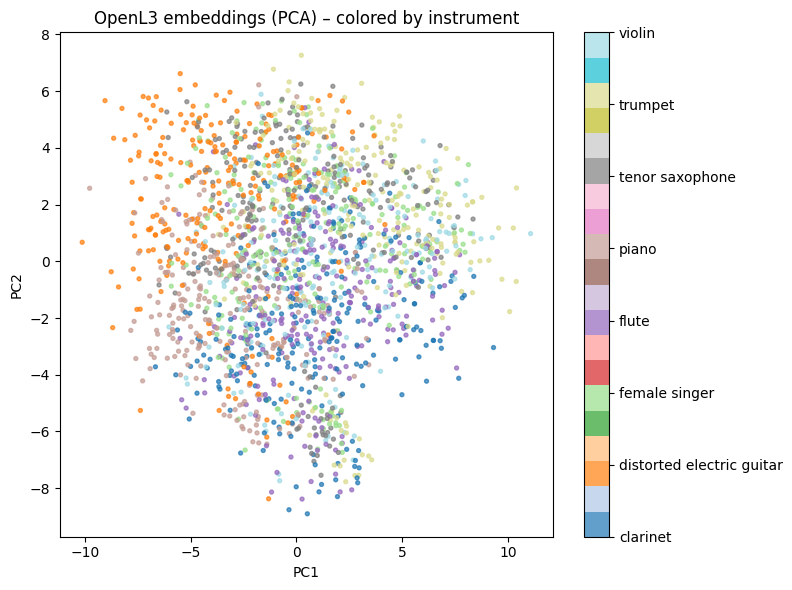

In [ ]:
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# sample a subset for speed
MAX_POINTS = 2000
indices = list(range(len(df)))
random.shuffle(indices)
indices = indices[:MAX_POINTS]

# load embeddings
X_l3 = []
inst_labels = []
rev_labels  = []

for i in indices:
    row = df.iloc[i]
    v = np.load(row["embed_openl3"])
    X_l3.append(v)
    inst_labels.append(row["instrument"])
    rev_labels.append(row["reverb_label"])

X_l3 = np.stack(X_l3, axis=0)  # [N, 512]

# PCA to 2D
pca = PCA(n_components=2)
X2 = pca.fit_transform(X_l3)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# ---- Color by instrument ----
plt.figure(figsize=(8,6))
uniq_inst = sorted(set(inst_labels))
color_map = {inst: i for i, inst in enumerate(uniq_inst)}
colors = [color_map[i] for i in inst_labels]

sc = plt.scatter(X2[:,0], X2[:,1], c=colors, s=8, alpha=0.7, cmap="tab20")
plt.title("OpenL3 embeddings (PCA) – colored by instrument")
plt.xlabel("PC1"); plt.ylabel("PC2")
cb = plt.colorbar(sc, ticks=range(len(uniq_inst)))
cb.ax.set_yticklabels(uniq_inst)
plt.tight_layout()
plt.show()


In [ ]:
from numpy.linalg import norm
import numpy as np

def cosine(a, b):
    return float(np.dot(a, b) / (norm(a)*norm(b) + 1e-9))

same_uuid_cos = []
random_cos    = []

grouped = df.groupby("uuid4")

uuids = [u for u,g in grouped if len(g) > 1]  # multiple versions (dry + reverbs)
print("UUIDs with multiple versions:", len(uuids))

# --- same-uuid pairs (dry vs some reverb, or reverb vs reverb) ---
for uuid in np.random.choice(uuids, size=min(100, len(uuids)), replace=False):
    g = grouped.get_group(uuid)
    if len(g) < 2:
        continue
    rows = g.sample(2, replace=False)
    v1 = np.load(rows.iloc[0]["embed_openl3"])
    v2 = np.load(rows.iloc[1]["embed_openl3"])
    same_uuid_cos.append(cosine(v1, v2))

# --- random pairs across different uuids ---
for _ in range(len(same_uuid_cos)):
    pair = df.sample(2, replace=False)
    r1 = pair.iloc[0]
    r2 = pair.iloc[1]
    v1 = np.load(r1["embed_openl3"])
    v2 = np.load(r2["embed_openl3"])
    random_cos.append(cosine(v1, v2))

print("Mean cos (same uuid):", np.mean(same_uuid_cos))
print("Mean cos (random):   ", np.mean(random_cos))


UUIDs with multiple versions: 1000
Mean cos (same uuid): 0.9883263337612153
Mean cos (random):    0.9769450032711029


# Unpack IRs & Ambiences

# Augments

obsolete

Sample usage, don't run

debug (obsolete)

# Metrics & Analysis

# Reusable clssifier head MLP/Conv1D

# OpenL3 Backbone

# Train OpenL3 plus head

# AudioMAE Backbone

# Train AudioMAE plus head

# Optional save heads